<a href="https://colab.research.google.com/github/tranrobin/stock-prediction/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
PYTHONPATH="${PYTHONPATH}:/usr/local/lib/python3.6/dist-packages/"

In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 13.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import sklearn.preprocessing as prep
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel(r"/content/drive/MyDrive/Job/Intern/KPIM/Dataset/stock.xlsx", index_col=None)
#,encoding='latin-1',error_bad_lines=False, lineterminator='\n')
df.head()

,id,symbol,trading_date,price_change,per_price_change,ceiling_price,floor_price,ref_price,open_price,highest_price,...,net_buy_sell_volume,net_buy_sell_value,total_traded_volume,total_traded_value,etl_date,id.1,market,symbol.1,stock_name,stock_en_name
0,1453,A32,2022-01-04,0,0.0,35800,26600,31200,30000,31800,...,0,0,0,0.0,NaN,1,UPCOM,A32,Công ty Cổ phần 32,32 Joint Stock Company
1,1454,A32,2022-01-05,100,0.3,34800,25800,30300,30400,30400,...,0,0,100,3040000.0,NaN,1,UPCOM,A32,Công ty Cổ phần 32,32 Joint Stock Company
2,1455,A32,2022-01-06,1500,4.9,34900,25900,30400,31000,31900,...,0,0,2100,65190000.0,NaN,1,UPCOM,A32,Công ty Cổ phần 32,32 Joint Stock Company
3,1456,A32,2022-01-07,1000,3.2,35600,26400,31000,31900,32000,...,0,0,4100,129400000.0,NaN,1,UPCOM,A32,Công ty Cổ phần 32,32 Joint Stock Company
4,1457,A32,2022-01-10,0,0.0,36300,26900,31600,31600,31600,...,0,0,100,3160000.0,NaN,1,UPCOM,A32,Công ty Cổ phần 32,32 Joint Stock Company


In [ ]:
#rmse fucntions
def rmse(a,b):
  return np.sqrt(np.mean(a-b)**2)

## Data Cleaning and EDA

In [ ]:
# Change trading_date from object to date_time
df['trading_date'] = pd.to_datetime(df['trading_date'])
df['trading_date']

0       2022-01-04
1       2022-01-05
2       2022-01-06
3       2022-01-07
4       2022-01-10
           ...    
86682   2022-05-24
86683   2022-05-25
86684   2022-05-26
86685   2022-05-27
86686   2022-05-30
Name: trading_date, Length: 86687, dtype: datetime64[ns]

In [ ]:
df_selected = df[['symbol','trading_date','price_change','ceiling_price', 'floor_price', 'open_price','close_price','highest_price', 'lowest_price']]
df_selected.columns = ['symbol','date','change','ceiling', 'floor', 'open','close','highest', 'lowest']
df_selected.head()

,symbol,date,change,ceiling,floor,open,close,highest,lowest
0,A32,2022-01-04,0,35800,26600,30000,31800,31800,30000
1,A32,2022-01-05,100,34800,25800,30400,30400,30400,30400
2,A32,2022-01-06,1500,34900,25900,31000,31900,31900,31000
3,A32,2022-01-07,1000,35600,26400,31900,32000,32000,31400
4,A32,2022-01-10,0,36300,26900,31600,31600,31600,31600


##Stock selections

In [ ]:
pd.set_option("max_rows", 20)
companies = ['A32', 'AAA', 'AAM', 'AAS', 'AAT', 'AAV', 'ABB', 'ABC', 'ABI','ABR','ABS', 'ABT', 'ACB', 'ACC', 'ACE', 'ACG', 'ACL', 'ACM','ACS', 'ACV']
df_selected.symbol.unique()

array(['A32', 'AAA', 'AAM', 'AAS', 'AAT', 'AAV', 'ABB', 'ABC', 'ABI',
       'ABR', 'ABS', 'ABT', 'ACB', 'ACC', 'ACE', 'ACG', 'ACL', 'ACM',
       'ACS', 'ACV', 'ADC', 'ADG', 'ADP', 'ADS', 'AFX', 'AG1', 'AGF',
       'AGG', 'AGM', 'AGP', 'AGR', 'AGX', 'AIC', 'ALT', 'ALV', 'AMC',
       'AMD', 'AME', 'AMP', 'AMS', 'AMV', 'ANT', 'ANV', 'APC', 'APF',
       'APG', 'APH', 'API', 'APL', 'APP', 'APS', 'APT', 'ARM', 'ART',
       'ASA', 'ASG', 'ASM', 'ASP', 'AST', 'ATA', 'ATB', 'ATG', 'ATS',
       'AUM', 'AVC', 'AVF', 'B82', 'BAB', 'BAF', 'BAL', 'BAX', 'BBC',
       'BBH', 'BBM', 'BBS', 'BBT', 'BCA', 'BCB', 'BCC', 'BCE', 'BCF',
       'BCG', 'BCM', 'BCP', 'BCV', 'BDB', 'BDG', 'BDT', 'BDW', 'BED',
       'BEL', 'BFC', 'BGW', 'BHA', 'BHC', 'BHG', 'BHK', 'BHN', 'BHP',
       'BHT', 'BIC', 'BID', 'BIG', 'BII', 'BIO', 'BKC', 'BKG', 'BKH',
       'BLF', 'BLI', 'BLN', 'BLT', 'BLW', 'BMC', 'BMD', 'BMF', 'BMG',
       'BMI', 'BMJ', 'BMN', 'BMP', 'BMS', 'BMV', 'BNA', 'BNW', 'BOT',
       'BPC', 'BQB',

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


In [ ]:
stock.shape
# (97, 8)

(97, 8)

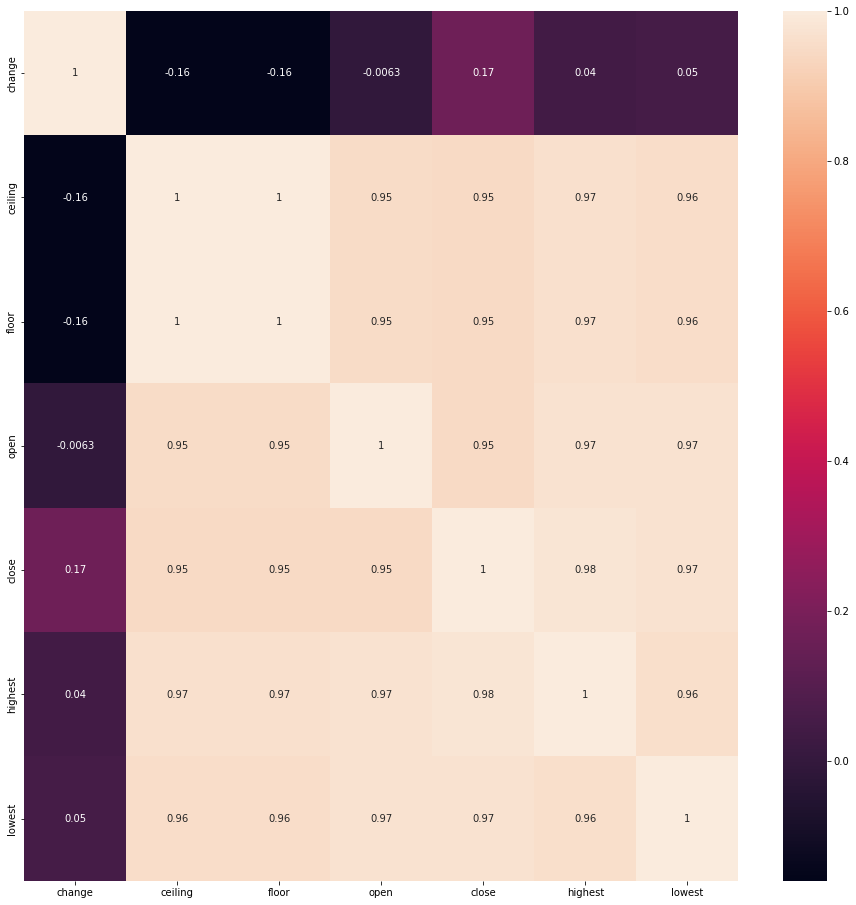

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(stock.corr(method = 'pearson'),annot = True)


## Visualization

In [ ]:
# Visualize closing price history: stationary
def plot_open_close_change(stock):
  fig, axs = plt.subplots(3, 1, figsize=(30,15))
  axs[0].plot(stock['open'])
  axs[1].plot(stock['close'])
  axs[2].plot(stock['change'])


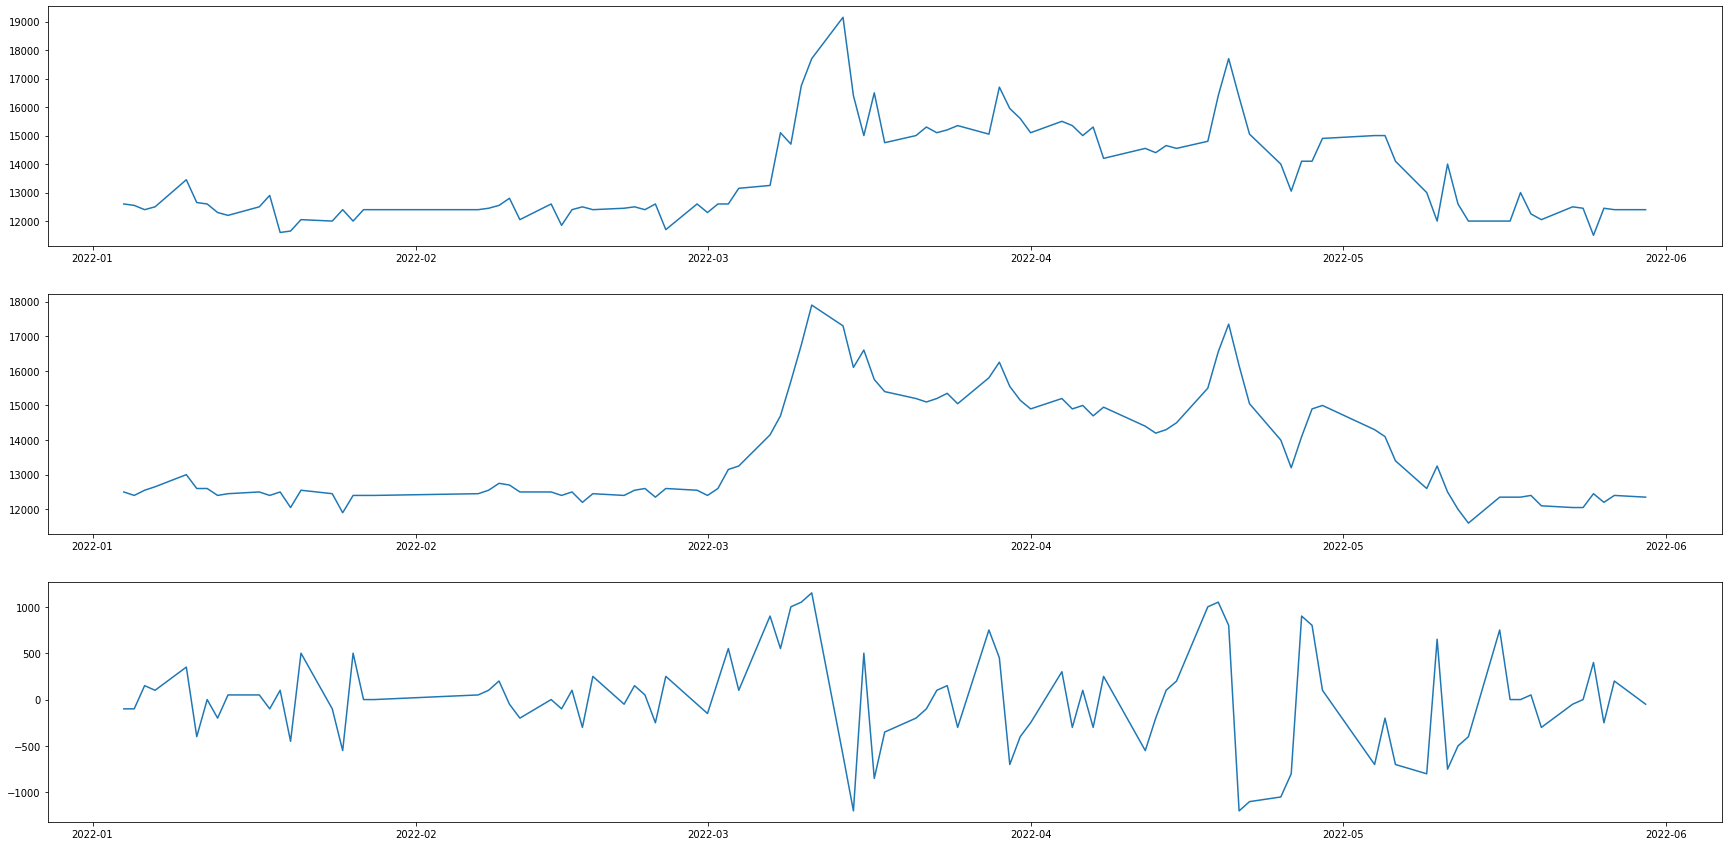

In [ ]:
plot_open_close_change(stock)

## Stationary checking using descriptive statistics checking and ADF

### Checking Stationary using descriptive statistics <br>
For stationary
- The MEAN value of them should be completely constant in the data during the analysis <br>
- The VARIANCE should be constant with respect to the time-frame <br>
- The COVARIANCE measures the relationship between two variables. <br>



In [ ]:
def descriptive_stationary_check(X):
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1 = %f, mean2 = %f' % (mean1, mean2))
    print('variance1 = %f, variance2 = %f' % (var1, var2))

In [ ]:
# Stationary checking using descriptvie statistics
print('descriptive_stationary_check for closing values')
descriptive_stationary_check(stock['close'].values)
print('descriptive_stationary_check for changing values')
descriptive_stationary_check(stock['change'].values)

descriptive_stationary_check for closing values
mean1 = 13189.583333, mean2 = 14116.326531
variance1 = 2245203.993056, variance2 = 2088815.077051
descriptive_stationary_check for changing values
mean1 = 65.625000, mean2 = -69.387755
variance1 = 194078.776042, variance2 = 302940.441483


### Cheking stationary using Augmented Dickey-Fuller (ADF) Test or Unit Root Test <br>
The ADF test is the most popular statistical test and with the following assumptions.<br>
<br>
Null Hypothesis (H0): Series is non-stationary <br>
Alternate Hypothesis (HA): Series is stationary <br>
p-value >0.05 Fail to reject (H0) <br>
p-value <= 0.05 Accept (H1)


In [ ]:
def adf_stationary_check(X,alpha):
    result = adfuller(X)
    print('1. ADF Statistic: %f' % result[0])
    print('2. p-value: %f' % result[1])
    print('3. Number of lags',result[2])
    print('4. Number of observations used',result[3])
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if  alpha > result[1]:
        print('reject H0(Series is non-stationary)')
        print('We are', (1-alpha)*100,'percent confident that the series is stationary')
    else:
        print('Can not reject H0(Series is non-stationary)')
        print('We do not have sufficient evidence to conclude that the series is stationary')





In [ ]:
for columns in ['change', 'open', 'close']:
    print(columns)
    adf_stationary_check(stock[columns],0.05)
    print('')


change
1. ADF Statistic: -7.464916
2. p-value: 0.000000
3. Number of lags 0
4. Number of observations used 96
5. Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
reject H0(Series is non-stationary)
We are 95.0 percent confident that the series is stationary

open
1. ADF Statistic: -2.464392
2. p-value: 0.124380
3. Number of lags 0
4. Number of observations used 96
5. Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Can not reject H0(Series is non-stationary)
We do not have sufficient evidence to conclude that the series is stationary

close
1. ADF Statistic: -2.119995
2. p-value: 0.236551
3. Number of lags 1
4. Number of observations used 95
5. Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
Can not reject H0(Series is non-stationary)
We do not have sufficient evidence to conclude that the series is stationary



## MA models

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


In [ ]:
def stock_MAs(stock,column):
  stock_feature = stock[[column]]
  stock_feature['predict SMA'] = stock[[column]].rolling(window = 3).mean()
  stock_feature['predict EMA'] = stock[[column]].ewm(span = 3).mean()
  stock_feature['predict CMA'] = stock[[column]].expanding().mean()
  # plt.figure(figsize= (16,8))
  # plt.plot(stock_feature['predict SMA'], label = 'predict SMA',linestyle="-",color='blue')
  # plt.plot(stock_feature['predict EMA'], label = 'predict EMA',linestyle="-",color='orange')
  # plt.plot(stock_feature['predict CMA'], label = 'predict CMA',linestyle="-",color='green')
  # plt.plot(stock[[column]], label = 'True value',linestyle="-",color='red')
  # plt.xlabel('Date',fontsize = 18)
  # plt.ylabel('Change in price (VND)',fontsize = 18)
  # plt.title("Moving Averages for stock AAM")
  # plt.legend()
  # plt.show()

  #rmse_SMA
  rmse_SMA = rmse(stock_feature['predict SMA'],stock_feature[column])
  #rmse_EMA
  rmse_EMA = rmse(stock_feature['predict EMA'],stock_feature[column])
  #rmse_CMA
  rmse_CMA = rmse(stock_feature['predict CMA'],stock_feature[column])

  # print("rmse_SMA:", rmse_SMA)
  # print("rmse_EMA:", rmse_EMA)
  # print("rmse_CMA:", rmse_CMA)
  print(rmse_SMA,rmse_EMA,rmse_CMA)
  return stock_feature



In [ ]:
for stock in companies:
  stock = df_selected[df_selected['symbol'] == stock]
  stock = stock.set_index('date')
  stock_MAs(stock = stock, column = 'close')

1.40350877192985 9.497799055984023 56.30074153488633
85.78947368421052 85.81460307648138 1809.5226366399074
0.7017543859648867 1.7299412257485791 510.254022416052
53.684210526315944 53.767563440129585 250.0565321833022
28.070175438596447 28.462778956028806 501.33592371146796
127.01754385964914 124.5351744087267 2748.321583074106
105.26315789473675 102.62152440117491 2923.066319799734
57.1929824561404 55.38843286061203 1242.4525177743958
98.94736842105263 98.62361002086637 882.6508310753096
76.14035087719304 70.46834878911137 1216.9599291520349
141.40350877192978 144.71005514840797 3271.599533367636
36.14035087719301 35.329390943843464 1583.4828014571997
21.40350877192985 27.74325518112723 894.7572487638296
244.21052631578962 198.18390382891684 2768.542371841728
17.543859649122936 14.628705442440516 703.0812118672663
403.8596491228071 408.5854799465534 9863.914463551446
88.24561403508777 84.48075522937191 3095.7045745797873
16.842105263157894 16.4957800501784 369.5203498147596
8.0701754

### SMA models

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


In [ ]:
def stock_SMAs(stock,column):
  stock_feature = stock[[column]]
  stock_feature['predict short SMA'] = stock[[column]].rolling(window = 5).mean()
  stock_feature['predict medium SMA'] = stock[[column]].rolling(window = 10).mean()
  stock_feature['predict long SMA'] = stock[[column]].rolling(window = 20).mean()
  plt.figure(figsize= (16,8))
  plt.plot(stock_feature['predict short SMA'], label = 'predict short SMA',linestyle="-",color='blue')
  plt.plot(stock_feature['predict medium SMA'], label = 'predict medium SMA',linestyle="-",color='orange')
  plt.plot(stock_feature['predict long SMA'], label = 'predict long SMA',linestyle="-",color='green')
  plt.plot(stock[[column]], label = 'True value',linestyle="-",color='red')
  plt.xlabel('Date',fontsize = 18)
  plt.ylabel('Change in price (VND)',fontsize = 18)
  plt.title("SMAs for stock AAM")
  plt.legend()
  plt.show()

  #rmse_SMA
  rmse_short_SMA = rmse(stock_feature['predict short SMA'],stock_feature[column])
  #rmse_EMA
  rmse_medium_SMA = rmse(stock_feature['predict medium SMA'],stock_feature[column])
  #rmse_CMA
  rmse_long_SMA = rmse(stock_feature['predict long SMA'],stock_feature[column])

  # print("rmse_short_SMA:", rmse_short_SMA)
  # print("rmse_medium_SMA:", rmse_medium_SMA)
  # print("rmse_long_SMA:", rmse_long_SMA)
  print(rmse_short_SMA, rmse_medium_SMA, rmse_long_SMA)
  # return stock_feature

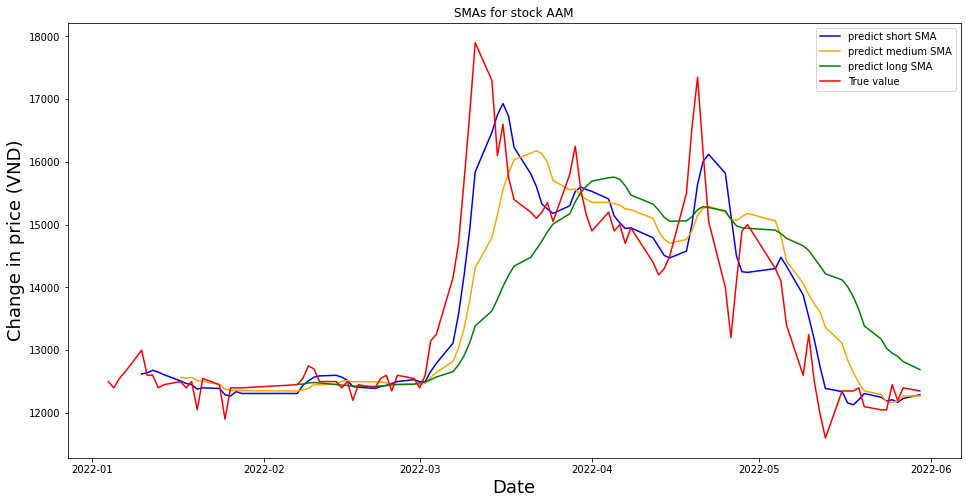

4.516129032258065 15.056818181818182 9.262820512820513


In [ ]:
stock_SMAs(stock,'close')

In [ ]:
for stock in companies:
  stock = df_selected[df_selected['symbol'] == stock]
  stock = stock.set_index('date')
  stock_SMAs(stock = stock, column = 'close')

22.150537634408604 82.1590909090909 202.37179487179486
202.04301075268816 381.25 681.25
4.516129032258065 15.056818181818182 9.262820512820513
125.59139784946237 222.8409090909091 226.47435897435898
57.74193548387097 83.23863636363636 131.92307692307693
251.3978494623656 524.7727272727273 1171.8589743589744
211.61290322580646 492.5 1214.3589743589744
113.54838709677419 235.45454545454547 424.1666666666667
205.3763440860215 423.6363636363636 738.5897435897435
158.06451612903226 179.54545454545453 188.3653846153846
316.02150537634407 772.2727272727273 1303.429487179487
89.24731182795699 251.8181818181818 750.6089743589744
48.064516129032256 145.6818181818182 492.46794871794873
230.0 463.6931818181818 870.7051282051282
45.376344086021504 134.3181818181818 204.6153846153846
838.7096774193549 1991.8181818181818 4615.0641025641025
173.01075268817203 372.5 1005.7692307692307
36.344086021505376 88.86363636363636 170.51282051282053
22.365591397849464 36.36363636363637 56.6025641025641
1.5053763

## EMA models

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


In [ ]:
def stock_EMAs(stock,column):
  stock_feature = stock[[column]]
  stock_feature['predict short EMA'] = stock[[column]].ewm(span = 5).mean()
  stock_feature['predict medium EMA'] = stock[[column]].ewm(span = 10).mean()
  stock_feature['predict long EMA'] = stock[[column]].ewm(span = 20).mean()
  plt.figure(figsize= (16,8))
  plt.plot(stock_feature['predict short EMA'], label = 'predict short EMA',linestyle="-",color='blue')
  plt.plot(stock_feature['predict medium EMA'], label = 'predict medium EMA',linestyle="-",color='orange')
  plt.plot(stock_feature['predict long EMA'], label = 'predict long EMA',linestyle="-",color='green')
  plt.plot(stock[[column]], label = 'True value',linestyle="-",color='red')
  plt.xlabel('Date',fontsize = 18)
  plt.ylabel('Change in price (VND)',fontsize = 18)
  plt.title("EMAs for stock AAM")
  plt.legend()
  plt.show()

  #rmse_SMA
  rmse_short_EMA = rmse(stock_feature['predict short EMA'],stock_feature[column])
  #rmse_EMA
  rmse_medium_EMA = rmse(stock_feature['predict medium EMA'],stock_feature[column])
  #rmse_CMA
  rmse_long_EMA = rmse(stock_feature['predict long EMA'],stock_feature[column])

  print("rmse_short_EMA:", rmse_short_EMA)
  print("rmse_medium_EMA:", rmse_medium_EMA)
  print("rmse_long_EMA:", rmse_long_EMA)
  return stock_feature

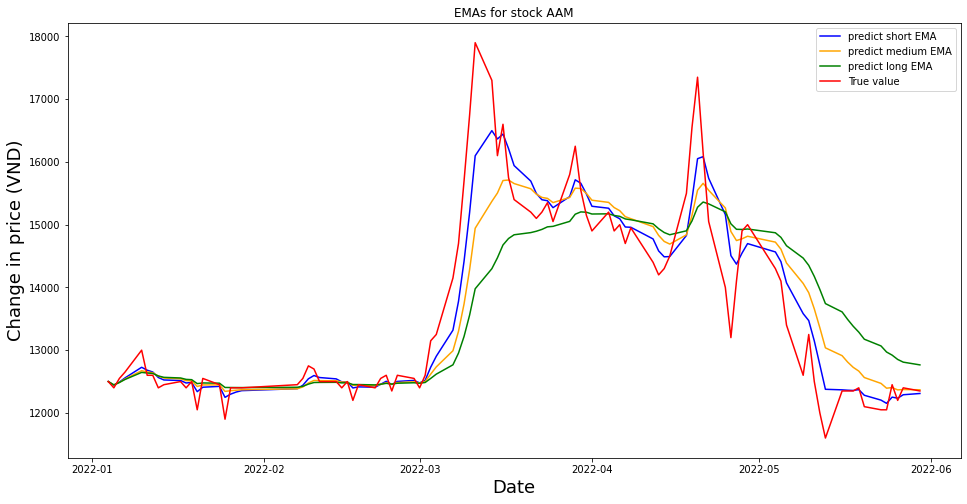

rmse_short_EMA: 4.314608450678561
rmse_medium_EMA: 7.357461821663164
rmse_long_EMA: 20.87635042686996


,close,predict short EMA,predict medium EMA,predict long EMA
date,,,,
2022-01-04,12500,12500.000000,12500.000000,12500.000000
2022-01-05,12400,12440.000000,12445.000000,12447.500000
2022-01-06,12550,12492.105263,12487.209302,12485.137386
2022-01-07,12650,12557.692308,12540.841584,12532.730673
2022-01-10,13000,12727.488152,12672.653477,12645.759147
...,...,...,...,...
2022-05-24,12050,12152.800919,12394.105317,12970.650423
2022-05-25,12450,12251.867279,12404.267987,12921.060598
2022-05-26,12200,12234.578186,12367.128353,12852.383060


In [ ]:
stock_EMAs(stock,'close')

## CMA models

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


In [ ]:
def stock_CMAs(stock,column):
  stock_feature = stock[[column]]
  stock_feature['predict CMA'] = stock[[column]].expanding().mean()

  # plotting
  plt.figure(figsize= (16,8))
  plt.plot(stock_feature['predict CMA'], label = 'predict CMA',linestyle="-",color='blue')
  plt.plot(stock[[column]], label = 'True value',linestyle="-",color='red')
  plt.xlabel('Date',fontsize = 18)
  plt.ylabel('Change in price (VND)',fontsize = 18)
  plt.legend()
  plt.show()

  # rmse_CMA
  rmse_CMA = rmse(stock_feature['predict CMA'],stock_feature[column])

  print("rmse_CMA:", rmse_CMA)
  return stock_feature

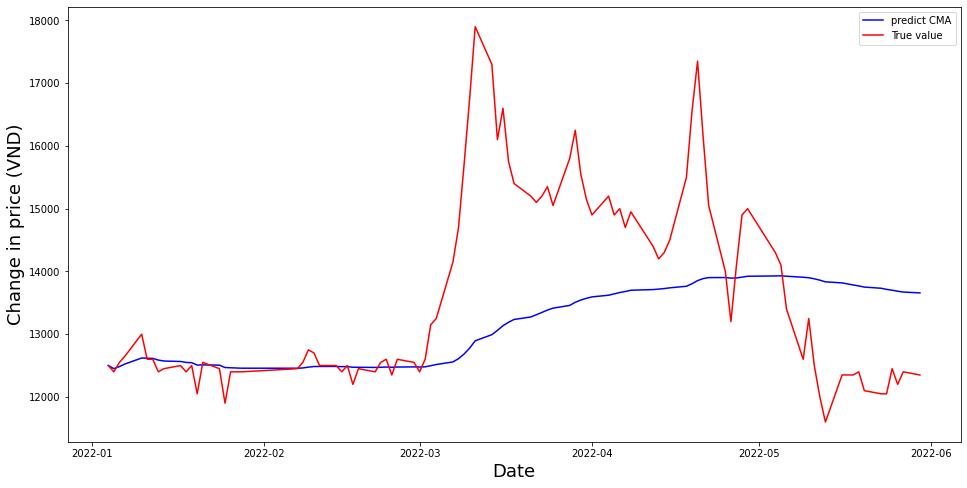

rmse_CMA: 510.254022416052


,close,predict CMA
date,,
2022-01-04,12500,12500.000000
2022-01-05,12400,12450.000000
2022-01-06,12550,12483.333333
2022-01-07,12650,12525.000000
2022-01-10,13000,12620.000000
...,...,...
2022-05-24,12050,13713.978495
2022-05-25,12450,13700.531915
2022-05-26,12200,13684.736842


In [ ]:
stock_CMAs(stock,'close')

## Auto regression models

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


### PACF and ACF

In [ ]:
def plot_pacf_acf(df,column,lag_nums):
  plt.figure(figsize= (16,8))
  pacf = plot_pacf(df[column], lags=lag_nums)
  acf = plot_acf(df[column], lags=lag_nums)
  plt.show()

### Autoregression Models

In [ ]:
def AR(stock,column,lags):
  testing_len = 27
  x = stock[column].values
  train = x[:len(x)-testing_len]
  test = x[len(x)-testing_len:]

  # Object Data type is accept all data-type
  Data_type = object
  np.array(train ,dtype = Data_type)


  # Build AR model
  model = AutoReg(train, lags = lags).fit()
  # print(model.summary())

  # Making Predictions
  pred = model.predict(start = len(train), end = len(x)-1,dynamic = False )
  future_pred = model.predict(start = len(train), end = len(x)+6,dynamic = False )

  # Plotting
  train_pred = train
  train_future_pred = train
  train_pred = np.concatenate((train_pred, pred), axis=None)
  plt.figure(figsize = (10,8))
  #train_future_pred = np.concatenate((train_future_pred, future_pred), axis=None)
  plt.plot(train_future_pred, color = 'g', label = 'predict future')
  plt.plot(train_pred, color = 'b', label = 'predict')
  plt.plot(x, color = 'r', label = 'real')
  plt.plot(train, label = 'train', color = 'k')
  plt.title("AR model directly")
  plt.legend()
  plt.show()

  # rmse
  print("The rmse value is:", round(rmse(pred,test),0))




In [ ]:
def AR_diff(stock,column,lags):
  change = stock['change'].values
  column = stock[column].values
  testing_len = 27
  change_train = change[:len(change)-testing_len]
  change_test = change[len(change)-testing_len:]
  column_train = column[:len(column)-testing_len]
  column_test = column[len(column)-testing_len:]

  # Object Data type is accept all data-type
  Data_type = object
  np.array(change_train,dtype = Data_type)


  # Build AR model
  model = AutoReg(change_train, lags = lags).fit()
  # print(model.summary())

  # Making Predictions
  change_pred = model.predict(start = len(change_train), end = len(change)-1,dynamic = False )
  change_future_pred = model.predict(start = len(change_train), end = len(change)+6,dynamic = False )

  change_train_pred = change_train
  change_train_future_pred = change_train
  change_train_pred = np.concatenate((change_train_pred, change_pred), axis=None)
  change_train_future_pred = np.concatenate((change_train_future_pred, change_future_pred), axis=None)

  # Plotting change
  plt.figure(figsize = (10,8))
  plt.plot(change_train_future_pred, color = 'g', label = 'predict future')
  plt.plot(change_train_pred, color = 'b', label = 'predict')
  plt.plot(change, color = 'r', label = 'real')
  plt.plot(change_train , label = 'train', color = 'k')
  plt.title('change plot')
  plt.legend()
  plt.show()

  column_pred = []
  a = column_train[-1]
  for i in change_pred:
    a+=i
    column_pred.append(a)

  column_future_pred = []
  a = column_train[-1]
  for i in change_train_future_pred:
    a+=i
    column_future_pred.append(a)

  # Plotting real close
  plt.figure(figsize = (16,8))
  plt.plot(column_pred)
  plt.plot(column_test)

  column_pred = np.array([column_pred])
  column_train_pred = column_train
  column_train_pred = np.concatenate((column_train_pred, column_pred), axis=None)
  column_train_pred = column_train_pred.reshape(97)
  stock['predict'] = column_train_pred.tolist()


  # Plotting real close
  plt.figure(figsize = (16,8))
  plt.plot(stock['predict'], color = 'b', label = 'predict')
  plt.plot(stock['close'], color = 'r', label = 'real')
  plt.plot(stock['close'].head(len(change)-testing_len), color = 'k', label = 'train')
  plt.title("AR model via differencing")
  plt.legend()
  plt.show()


  # rmse
  print("The rmse value is for change:", round(rmse(change_pred,change_test),0))
  print("The rmse value is for close:", round(rmse(column_pred,column_test),0))
  print("Last value error = ", round(stock['predict'][-1] - stock['close'][-1]))
  print("future prediction for chaging value:", column_future_pred[-7:])

<Figure size 1152x576 with 0 Axes>

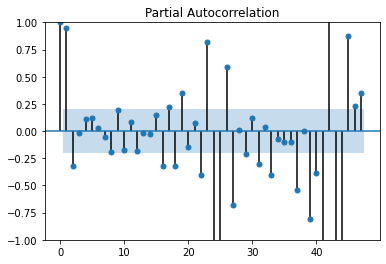

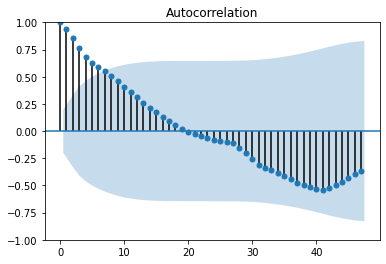

In [ ]:
plot_pacf_acf(stock,'close',47)

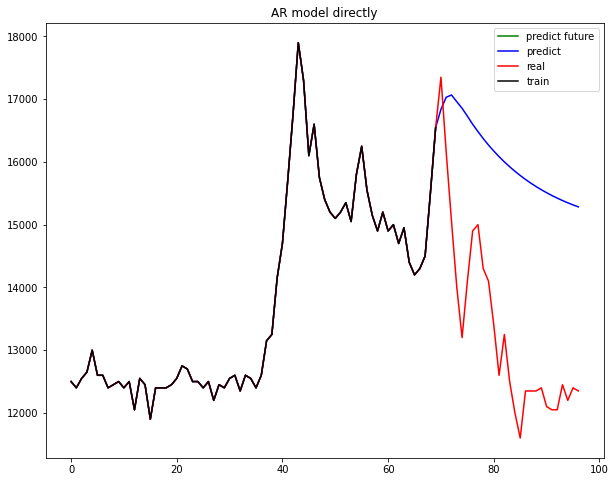

The rmse value is: 2768.0


In [ ]:
AR(stock,'close',5)

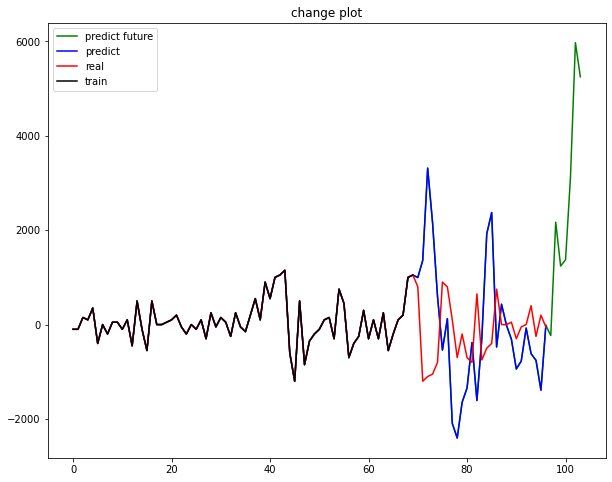

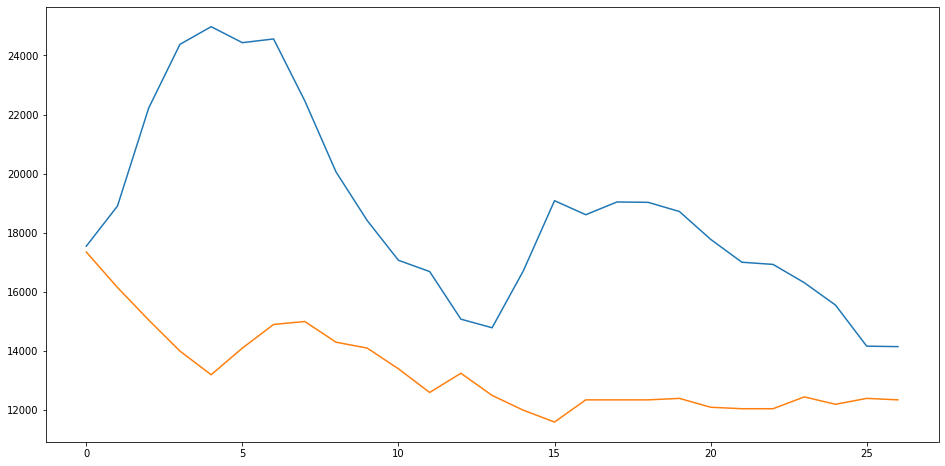

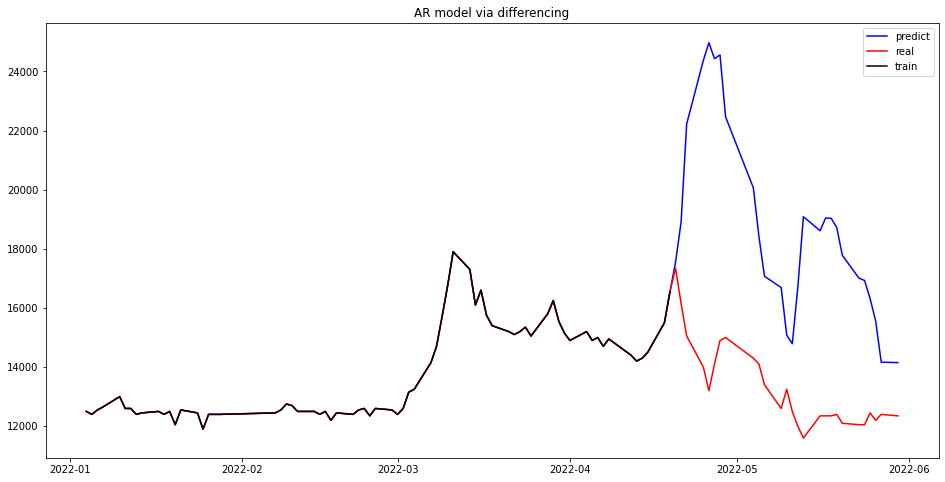

The rmse value is for change: 67.0
The rmse value is for close: 5411.0
Last value error =  1801
future prediction for chaging value: [17867.384785170674, 20035.905360668698, 21276.159745134344, 22649.9330196874, 25780.954398545957, 31752.75933928286, 37002.34603162942]


In [ ]:
AR_diff(stock,'close',lags= 30)

## ARIMA

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


### PACF and ACF

In [ ]:
def plot_pacf_acf(df,column,lag_nums):
  plt.figure(figsize= (16,8))
  pacf = plot_pacf(df[column], lags=lag_nums)
  acf = plot_acf(df[column], lags=lag_nums)
  plt.show()

### ARIMA

In [ ]:
def ARIMA_model(stock,column,p,i,q):
  testing_len = 27
  x = stock[column].values
  train = x[:len(x)-testing_len]
  test = x[len(x)-testing_len:]

  # Object Data type is accept all data-type
  Data_type = object
  np.array(train ,dtype = Data_type)

  # Build ARIMA model
  model = sm.tsa.arima.ARIMA(train,order=(p,i,q)).fit()
  # print(model.summary())

  # Making Predictions
  pred = model.predict(start = len(train), end = len(x)-1,dynamic = False )
  future_pred = model.predict(start = len(train), end = len(x)+6,dynamic = False )

  # Plotting
  train_pred = train
  train_future_pred = train
  train_pred = np.concatenate((train_pred, pred), axis=None)
  plt.figure(figsize = (10,8))
  #train_future_pred = np.concatenate((train_future_pred, future_pred), axis=None)
  plt.plot(train_future_pred, color = 'g', label = 'predict future')
  plt.plot(train_pred, color = 'b', label = 'predict')
  plt.plot(x, color = 'r', label = 'real')
  plt.plot(train, label = 'train', color = 'k')
  plt.title("ARIMA model directly")
  plt.legend()
  plt.show()

  # rmse
  print("The rmse value is:", round(rmse(pred,test),0))

In [ ]:
def ARIMA_diff(stock,column,p,i,q):
  change = stock['change'].values
  column = stock[column].values
  testing_len = 27
  change_train = change[:len(change)-testing_len]
  change_test = change[len(change)-testing_len:]
  column_train = column[:len(column)-testing_len]
  column_test = column[len(column)-testing_len:]

  # Object Data type is accept all data-type
  Data_type = object
  np.array(change_train,dtype = Data_type)


  # Build AR model
  model = sm.tsa.arima.ARIMA(change_train,order=(p,i,q)).fit()
  print(model.summary())

  # Making Predictions
  change_pred = model.predict(start = len(change_train), end = len(change)-1,dynamic = False )
  change_future_pred = model.predict(start = len(change_train), end = len(change)+6,dynamic = False )

  change_train_pred = change_train
  change_train_future_pred = change_train
  change_train_pred = np.concatenate((change_train_pred, change_pred), axis=None)
  change_train_future_pred = np.concatenate((change_train_future_pred, change_future_pred), axis=None)

  # Plotting change
  plt.figure(figsize = (10,8))
  plt.plot(change_train_future_pred, color = 'g', label = 'predict future')
  plt.plot(change_train_pred, color = 'b', label = 'predict')
  plt.plot(change, color = 'r', label = 'real')
  plt.plot(change_train , label = 'train', color = 'k')
  plt.title('change plot')
  plt.legend()
  plt.show()

  column_pred = []
  a = column_train[-1]
  for i in change_pred:
    a+=i
    column_pred.append(a)

  column_future_pred = []
  a = column_train[-1]
  for i in change_train_future_pred:
    a+=i
    column_future_pred.append(a)

  # Plotting real close
  plt.figure(figsize = (10,8))
  plt.plot(column_pred)
  plt.plot(column_test)

  column_pred = np.array([column_pred])
  column_train_pred = column_train
  column_train_pred = np.concatenate((column_train_pred, column_pred), axis=None)
  column_train_pred = column_train_pred.reshape(97)
  stock['predict'] = column_train_pred.tolist()


  # Plotting real close
  plt.figure(figsize = (10,8))
  plt.plot(stock['predict'], color = 'b', label = 'predict')
  plt.plot(stock['close'], color = 'r', label = 'real')
  plt.plot(stock['close'].head(len(change)-testing_len), color = 'k', label = 'train')
  plt.title("ARIMA model via differencing")
  plt.legend()
  plt.show()


  # rmse
  print("The rmse value is for change:", round(rmse(change_pred,change_test),0))
  print("The rmse value is for close:", round(rmse(column_pred,column_test),0))
  print("Last value error = ", round(stock['predict'][-1] - stock['close'][-1]))
  print("future prediction for chaging value:", column_future_pred[-7:])
  print(model.summary())

<Figure size 1152x576 with 0 Axes>

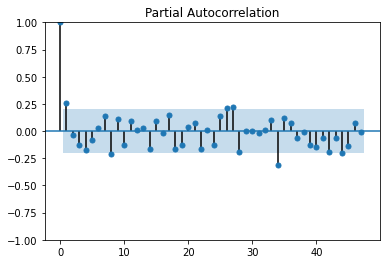

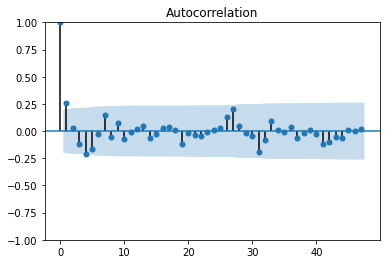

In [ ]:
plot_pacf_acf(stock,'change',47)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:                ARIMA(33, 1, 9)   Log Likelihood                -563.193
Date:                Sat, 09 Jul 2022   AIC                           1212.387
Time:                        03:20:33   BIC                           1308.453
Sample:                             0   HQIC                          1250.500
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1134      4.549      0.025      0.980      -8.802       9.028
ar.L2          0.1878      3.379      0.056      0.956      -6.435       6.811
ar.L3         -0.1412      1.232     -0.115      0.9

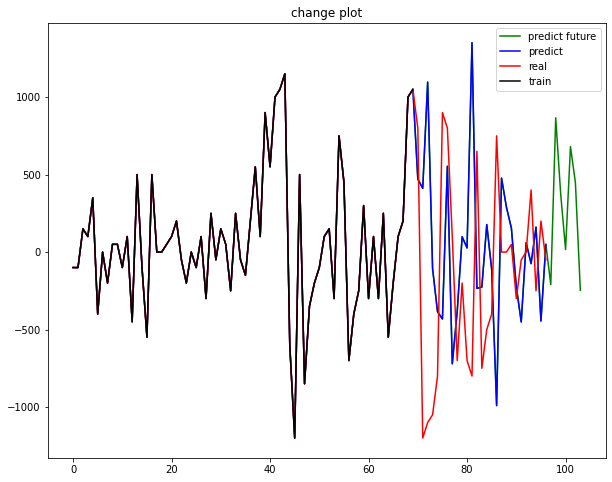

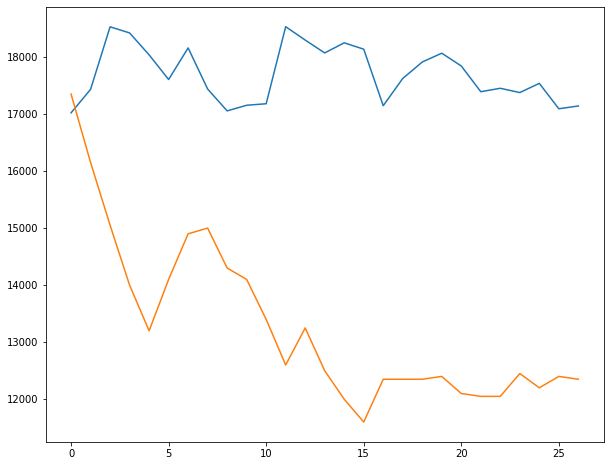

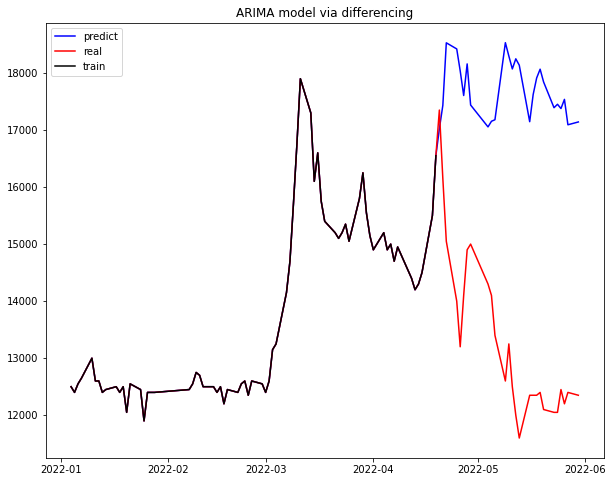

The rmse value is for change: 177.0
The rmse value is for close: 4420.0
Last value error =  4791
future prediction for chaging value: [20880.989669994273, 21747.41246335841, 22126.173699353534, 22142.653484196235, 22823.310372677348, 23270.339188190726, 23023.57070258831]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:                ARIMA(33, 1, 9)   Log Likelihood                -563.193
Date:                Sat, 09 Jul 2022   AIC                           1212.387
Time:                        03:20:34   BIC                           1308.453
Sample:                             0   HQIC                          1250.500
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------

In [ ]:
ARIMA_diff(stock,'close',33,1,9)

## LSTM models

### Univariate

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
from ssl import ALERT_DESCRIPTION_USER_CANCELLED
def LSTM_univariate(stock,column, window_size,training_len):
  # Checking only the feature value of stock
  stock_feature = stock.filter([column])
  # Convert stock_feature into NumPy array
  np_stock_feature = stock_feature.values
  # Split the data_set into 90 and 7
  training_len = training_len


  # Scale the data
  # Scale the data
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_stock_feature = scaler.fit_transform(np_stock_feature)

  train  = scaled_stock_feature[:training_len]
  x_train = []
  y_train = []

  window_size = window_size
  for i in range (window_size,len(train)):
      x_train.append(train[i-window_size:i,0])
      y_train.append(train[i,0])

  # convert x_train,y_train to numpy array
  x_train = np.array(x_train)
  y_train = np.array(y_train)

  # reshape the data
  x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)

  # build the LSTM models
  model = Sequential()
  model.add(LSTM(120,return_sequences = True, input_shape = (x_train.shape[1],1)))
  model.add(LSTM(100,return_sequences = False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the models
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Train the model
  model.fit(x_train,y_train,batch_size = 128,epochs = 50)

  # Create the testing dataset
  # Create a new array containing scaled values from index
  test = scaled_stock_feature[training_len-window_size:]
  # Create the datasets x_test and y_test
  x_test = []
  y_test = np_stock_feature[training_len:,:]
  for i in range(window_size,len(test)):
      x_test.append(test[i-window_size:i,0])

  # transform x_test to an numpy array
  x_test = np.array(x_test)
  x_test.shape

  x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

  pred = model.predict(x_test)
  pred = scaler.inverse_transform(pred)

  # Plotting
  training = np_stock_feature[:training_len]
  testing = np_stock_feature[training_len:]
  train_pred = training
  train_pred = np.concatenate((train_pred,pred), axis=None)
  plt.figure(figsize = (16,8))
  plt.plot(train_pred, label = 'predict', color = 'b')
  plt.plot(np_stock_feature, label = 'true', color = 'r')
  plt.plot(training, label ='train', color = 'k')
  plt.title("LSTM model")
  plt.legend()
  rmse_LSTM = rmse(testing,pred)
  print("rmse value:",rmse_LSTM)
  print("Last value error:", int(pred[-1]-testing[-1]))
  print("Percent last value error:",float((pred[-1]-testing[-1])/testing[-1]*100))


  # Trend evaluation
  print("start",float(training[-1]))
  print("predict",float(pred[-1]))
  print("real",float(testing[-1]))
  print([float(training[-1]),float(pred[-1]),float(testing[-1])])

  if pred[-1]<0.95*training[-1]:
    prediction = "up"
    print("predicted downtrend")
  elif pred[-1]>1.05*training[-1]:
    print("predicted uptrend")
    prediction = "down"
  else:
    print("predicted sideway market")
    prediction = "side"

  if testing[-1]<0.95*training[-1]:
    actual = "up"
    print("actual downtrend")
  elif testing[-1]>1.05*training[-1]:
    print("actual uptrend")
    actual = "down"
  else:
    print("actual sideway market")
    actual = "side"
  print
  if actual == prediction:
    print("Correct trend prediction")
  else:
    print("False trend prediction")





AAM
Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.2172
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 0.1918
Epoch 3/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1684
Epoch 4/50
1/1 [==============================] - 0s 17ms/step - loss: 0.1463
Epoch 5/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1251
Epoch 6/50
1/1 [==============================] - 0s 18ms/step - loss: 0.1047
Epoch 7/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0851
Epoch 8/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0670
Epoch 9/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0509
Epoch 10/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0380
Epoch 11/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0298
Epoch 12/50
1/1 [==============================] - 0s 17ms/step - loss: 0.0277
Epoch 13/50
1/1 [==============================] - 0s 18ms/

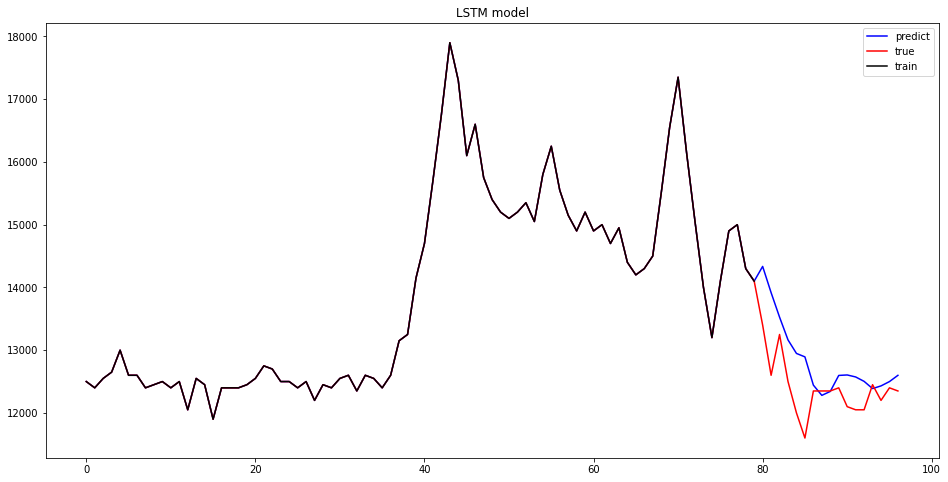

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()
LSTM_univariate(stock,column = 'close',window_size = 3,training_len = 80)

In [ ]:
stock = str(input())
stock = df_selected[df_selected['symbol'] == stock]
stock = stock.set_index('date')
stock.head()

AAM


,symbol,change,ceiling,floor,open,close,highest,lowest
date,,,,,,,,
2022-01-04,AAM,-100,13450,11750,12600,12500,12800,12500
2022-01-05,AAM,-100,13350,11650,12550,12400,12700,12400
2022-01-06,AAM,150,13250,11550,12400,12550,12600,12400
2022-01-07,AAM,100,13400,11700,12500,12650,12700,12500
2022-01-10,AAM,350,13500,11800,13450,13000,13450,12700


Multivariate

In [ ]:
def standard_scaler(X_train, X_test):
    # X_train,Y_train now have 3 dimension (sample_num,windows,feature)
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape

    # reshape into 2D array to fit into Standard Scaler
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))


    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)

    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))

    return X_train, X_test

In [ ]:
def preprocess_data(stock, window_size):
    # check feature amount
    amount_of_features = len(stock.columns)
    # check stock value from df to 2D numpy array
    data = stock.values

    sequence_length = window_size + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
    '''

    window_size = 3 --> sequqnce length = 4
    Let say data = day 1 to day 10 (each day has 6 features)
    len(data) = 10
    --> index in range 6 (from 0 to 5)
    result[] first append data[0:4] (index = 0,1,2,3) (day 1,2,3,4)
    result[] then append data[1:5] (index = 1,2,3,4)  (day 2,3,4,5)
    ....
    result[] then append data[5:8] (index = 5,6,7,8)  (day 6,7,8,9)

    '''

    # result is now a 3d array(sample_num,window_size+1,features)
    # change result to np array
    result = np.array(result)
    train_len = round(0.9 * result.shape[0])
    train = result[: int(train_len), :]
    test = result[int(train_len):, :]

    # Scale the dataset with standard scaler
    train, result = standard_scaler(train, result)

    x_train = train[:, : -1] # x_train is now a 3d array(sample_num,window_size,features)
    y_train = train[:, -1][: ,-1] # y_train is now a 3d array(sample_num,window_size,features)
    x_test = test[:,: -1] # x_test is now a 3d array(sample_num,window_size,features)
    y_test = test[:, -1][: ,-1] # y_test is now a 3d array(sample_num,window_size,features)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]

### Multivariate

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [ ]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    #start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    #print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
preprocess_data(stock,3)

NameError: ignored